In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
import pandas as pd
df=pd.read_csv("C://Users//vignesh//Downloads//train_tweets.csv")
df.head(5)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [9]:
#DOWNSAMPLING
2242/29720

0.07543741588156123

In [10]:
df_pos = df[df['label']==1]
df_pos.shape

(2242, 3)

In [11]:
df_neg = df[df['label']==0]
df_neg.shape

(29720, 3)

In [12]:
df_neg_downsampled = df_neg.sample(df_pos.shape[0])
df_neg_downsampled.shape

(2242, 3)

In [13]:
df_balanced = pd.concat([df_neg_downsampled, df_pos])
df_balanced.shape

(4484, 3)

In [14]:
df_balanced['label'].value_counts()

0    2242
1    2242
Name: label, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['tweet'],df_balanced['label'], stratify=df_balanced['label'])

In [16]:
X_train.head(5)

17013    @user racist schools are teaching students tha...
4730     completely #bored... #sucks to be alone and th...
19867    that moment when you excitedly look at your ra...
23093    one of the #best pictures i'd ever take!! see ...
8639     university of wisconsin-madison won't cancel r...
Name: tweet, dtype: object

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
# Bert layers 
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [20]:
len(X_train)

3363

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
106/106 [==============================] - 801s 7s/step - loss: 0.6562 - accuracy: 0.6149 - precision: 0.6197 - recall: 0.5957
Epoch 2/10
106/106 [==============================] - 891s 8s/step - loss: 0.5999 - accuracy: 0.6997 - precision: 0.7041 - recall: 0.6891
Epoch 3/10
106/106 [==============================] - 747s 7s/step - loss: 0.5693 - accuracy: 0.7339 - precision: 0.7467 - recall: 0.7081
Epoch 4/10
106/106 [==============================] - 780s 7s/step - loss: 0.5415 - accuracy: 0.7484 - precision: 0.7509 - recall: 0.7438
Epoch 5/10
106/106 [==============================] - 794s 7s/step - loss: 0.5231 - accuracy: 0.7696 - precision: 0.7794 - recall: 0.7521
Epoch 6/10
106/106 [==============================] - 786s 7s/step - loss: 0.5062 - accuracy: 0.7743 - precision: 0.7809 - recall: 0.7628
Epoch 7/10
106/106 [==============================] - 751s 7s/step - loss: 0.4967 - accuracy: 0.7704 - precision: 0.7778 - recall: 0.7574
Epoch 8/10
106/106 [==============

In [23]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 292s 8s/step - loss: 0.4737 - accuracy: 0.8055 - precision: 0.8214 - recall: 0.7804


[0.4737412631511688,
 0.8055307865142822,
 0.8214285969734192,
 0.7803571224212646]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

36/36 [==============================] - 339s 9s/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 1])

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[466,  95],
       [123, 437]], dtype=int64)

Text(33.0, 0.5, 'Truth')

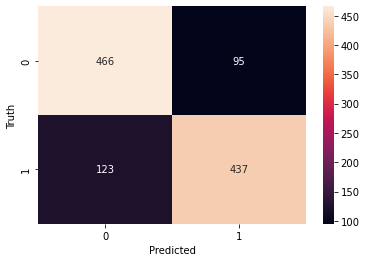

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       561
           1       0.82      0.78      0.80       560

    accuracy                           0.81      1121
   macro avg       0.81      0.81      0.81      1121
weighted avg       0.81      0.81      0.81      1121

